In [1]:
import pandas as pd
import ast,json
import numpy as np
from pymatgen.core import Composition
import CompositionDeformer as compd
from tensorflow.keras.utils import to_categorical
print("hello new materials")
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model
from tensorflow.keras.models import clone_model
from IPython.display import Image
import tqdm
from tensorflow.keras.layers import Activation, Conv2D, Dense, Flatten, MaxPooling2D, Dropout
from tensorflow.keras.models import Sequential, Model

hello new materials


In [2]:
loaded_model= load_model("./models/201231_ES_custom_50ep_50try.h5")

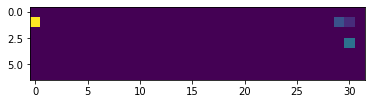

In [4]:
import CompositionDeformer as compd
COMPOSITION = "Li4OBr1.5F0.5"
compdef = compd.generate_extended_PT_from_composition(COMPOSITION)
compdef.draw_PT_img()

In [3]:
from pymatgen.symmetry.groups import SpaceGroup
demo_1d_arrays = []
for i,composition_name in enumerate(["Li4OBr2"]):
    demo_1d_arrays.append(compd.generate_extended_PT_from_composition(composition_name).get_1d_array())
#入力データを2次元マップに変換
demo_data = np.array(demo_1d_arrays, dtype = np.float32)
demo_data = demo_data.reshape((len(demo_data),7,32))
#予測
predicted_space_groups = loaded_model.predict(demo_data)[0][0]
#order by possibilities
sorted_arg = np.argsort(predicted_space_groups)[::-1]
for arg in sorted_arg:
    print(SpaceGroup.from_int_number(arg).symbol + ":\t" + str(predicted_space_groups[arg]))

Fm-3m:	0.1009115
P4/mmm:	0.06231773
Pnma:	0.046725515
Pm-3m:	0.04398282
R-3mH:	0.0430159
F-43m:	0.040314943
P-3m1:	0.04000348
P6_3/mmc:	0.035250783
Immm:	0.03427966
I4/mmm:	0.031531945
P4/nmm1:	0.029205523
P12_1/c1:	0.026248548
P6_3mc:	0.02613527
P1:	0.02448571
P6_3cm:	0.023009174
C12/m1:	0.022481864
R3mH:	0.01886631
C1m1:	0.017707765
P4_2/nmc:	0.016778603
R-3H:	0.013685844
I4/m:	0.012378461
Ibam:	0.011822345
C12/c1:	0.010693282
I4_1/amd:	0.0105799725
Fd-3m1:	0.010532029
Pmmn1:	0.010481847
P2_13:	0.010123875
P-6m2:	0.009927995
C1c1:	0.009348227
P1m1:	0.008639253
Cmcm:	0.008445805
P12_1/m1:	0.008382621
P4mm:	0.008063625
Amm2:	0.007865709
P-1:	0.007861029
P-62m:	0.007839251
Ia-3:	0.0077343564
Cmce:	0.00747413
Pmm2:	0.006272864
I4/mcm:	0.0062005636
Cmmm:	0.005467708
Pa-3:	0.00531179
P3m1:	0.005223031
P4_2/mnm:	0.0048147803
Pmmm:	0.004691836
P-43m:	0.0043686386
R-3cH:	0.004344734
P-4m2:	0.0042892126
P-43n:	0.0037780744
Cmc2_1:	0.0037696273
I-4m2:	0.0037253548
Pbca:	0.00367922
I-43d:	0.0034

ValueError: Invalid international number!

## evaluation of parent model

In [4]:
# import materials project database
seeddata = pd.read_csv("./database/materials_project/mp_all_data.csv",index_col=0)
# add 1d periodic table array and normalized magnifications
normalized_magnifications = []
composition_names = []
normalized_compositions = []

for unit in tqdm.tqdm(seeddata["unit_cell_formula"]):
    compdict = ast.literal_eval(unit)
    composition_name = ""
    for item in compdict.items():
        composition_name += item[0] + str(item[1])
    #print(f"composition name: {composition_name}")
    composition_names.append(composition_name)
    #組成の規格化
    comp = Composition(composition_name)
    normalized_compositions.append(comp.fractional_composition.reduced_formula)
    ratio_list = {}
    for el,ratio in comp.fractional_composition.as_dict().items():
        ratio_list[el] = ratio
    #規格化後の倍率を取得
    normalized_magnification = [ratio_list[key]/compdict[key] for key in compdict.keys()][0]
    #print(f"normalized magnification: {normalized_magnification}")
    normalized_magnifications.append(normalized_magnification)

  9%|▉         | 11150/126335 [00:01<00:11, 10103.19it/s]/home/wshogo/.local/lib/python3.7/site-packages/pymatgen/core/periodic_table.py:426: UserWarning: No electronegativity for Ne. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  % self.symbol)
 10%|▉         | 12168/126335 [00:01<00:11, 10124.18it/s]/home/wshogo/.local/lib/python3.7/site-packages/pymatgen/core/periodic_table.py:426: UserWarning: No electronegativity for He. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  % self.symbol)
 36%|███▋      | 45807/126335 [00:04<00:07, 10194.85it/s]/home/wshogo/.local/lib/python3.7/site-packages/pymatgen/core/periodic_table.py:426: UserWarning: No electronegativity for Ar. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  % self.symbol)
100%|██████████| 126335/126335 [00:12<00

In [5]:
print(seeddata.keys())
##エネルギーを規格化しseeddataに追加
energy_array = np.array(seeddata["energy"],dtype=np.float32)
magnifications_array = np.array(normalized_magnifications,dtype=np.float32)
normalized_energy = energy_array*magnifications_array
seeddata["normalized_energy"] = normalized_energy
##normalized_magnificationを追記
seeddata["normalized_magnification"] = normalized_magnifications
##compositionを追記
seeddata["composition_name"] = composition_names
##normalized_compositionsを追記
seeddata["normalized_composition"] = normalized_compositions
print(seeddata.keys())

Index(['pretty_formula', 'unit_cell_formula', 'energy', 'energy_per_atom',
       'band_gap', 'symmetry', 'is_hubbard', 'hubbards', 'is_compatible',
       'icsd_id', 'elasticity', 'piezo', 'diel', 'formation_energy_per_atom'],
      dtype='object')
Index(['pretty_formula', 'unit_cell_formula', 'energy', 'energy_per_atom',
       'band_gap', 'symmetry', 'is_hubbard', 'hubbards', 'is_compatible',
       'icsd_id', 'elasticity', 'piezo', 'diel', 'formation_energy_per_atom',
       'normalized_energy', 'normalized_magnification', 'composition_name',
       'normalized_composition'],
      dtype='object')


In [6]:
#重複する組成データのうちエネルギーが最も低いもののみ残す
##エネルギー順に並び変え
sorted_seeddata = seeddata.sort_values(['normalized_composition','normalized_energy'])
print(sorted_seeddata.shape)
##重複した組成式のうち一番上（昇順なので一番上が最安定）のみ残して削除
dropped_seeddata = sorted_seeddata.drop_duplicates(keep='first',subset='normalized_composition')
##DFT + Uを使っている計算を排除
dropped_seeddata = dropped_seeddata[dropped_seeddata['is_hubbard'] != True]
##互換性のある計算のみ取得
dropped_seeddata = dropped_seeddata[dropped_seeddata['is_compatible'] != False]
print(dropped_seeddata.shape)
print(dropped_seeddata["is_hubbard"][:100])

(126335, 18)
(70961, 18)
32922     False
24167     False
3918      False
115907    False
99922     False
          ...  
60226     False
123179    False
45235     False
29188     False
54931     False
Name: is_hubbard, Length: 100, dtype: bool


In [7]:
#拡張周期表表記の入力配列を作成
periodic_1d_arrays = []
for composition_name in tqdm.tqdm(dropped_seeddata['normalized_composition']):
    periodic_1d_arrays.append(compd.generate_extended_PT_from_composition(composition_name).get_1d_array())
#入力データを2次元マップに変換
X = np.array(periodic_1d_arrays, dtype = np.float32)
X = X.reshape((len(X),7,32))
print(X.shape)

##バンドギャップをnumpy配列化
band_gap_array = np.array(dropped_seeddata["band_gap"],dtype=np.float32)
##空間群をcategorical配列に変換
symmetry_category = to_categorical(dropped_seeddata["symmetry"])

100%|██████████| 70961/70961 [00:03<00:00, 19651.23it/s]

(70961, 7, 32)


In [8]:
#訓練用データセットに分ける
from sklearn.model_selection import train_test_split
# X_train,X_test,bandgap_train,bandgap_test,symmetry_train,symmetry_test = train_test_split(X,band_gap_array,symmetry_category,test_size=0.1)
X_train,X_test,energy_train,energy_test,symmetry_train,symmetry_test = train_test_split(X,dropped_seeddata["normalized_energy"],symmetry_category,test_size=0.1)

In [23]:
print(loaded_model.evaluate(X_train,[symmetry_train,energy_train]))

1996/1996 [==============================] - 16s 8ms/step - loss: 2.5797 - classification_head_1_loss: 2.4178 - regression_head_1_loss: 0.1618 - classification_head_1_accuracy: 0.4074 - regression_head_1_mean_absolute_error: 0.2580
[2.5796608924865723, 2.417813777923584, 0.16184818744659424, 0.4074282944202423, 0.2580157220363617]


## visualization of prediction

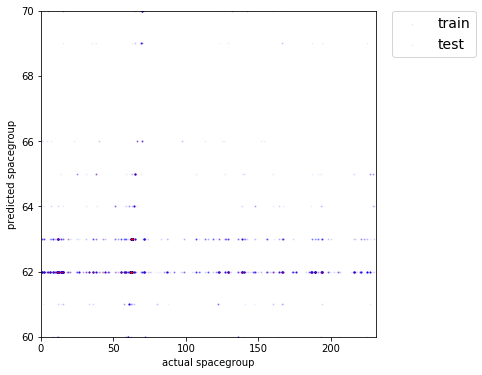

In [54]:
#test値の評価
import matplotlib.pyplot as plt
#visualization of train and test prediction
## energy
# predicted_spacegroup = np.argmax(loaded_model.predict(X_train)[:][0],axis=1)
# actual_spacegroup =  np.argmax(symmetry_train,axis=1)

# predicted_spacegroup_test = np.argmax(loaded_model.predict(X_test)[:][0],axis=1)
# actual_spacegroup_test =  np.argmax(symmetry_test,axis=1)
plt.figure(figsize=(6,6))
plt.scatter(actual_spacegroup,predicted_spacegroup,alpha =0.05,s=1,color="blue",label="train")
plt.scatter(actual_spacegroup_test,predicted_spacegroup_test,alpha =0.05,s=1,color="red",label="test")
# lgnd = plt.legend(loc="upper right", bbox_to_anchor=(0.5,-0.05), ncol=2)
lgnd = plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=14)
plt.title('')
plt.xlim(0,231)
plt.ylim(60,70)
plt.ylabel('predicted spacegroup')
plt.xlabel('actual spacegroup')
plt.savefig("./spacegroup_artifact_70.png",bbox_extra_artists=(lgnd,), bbox_inches='tight',dpi=200)
plt.show()

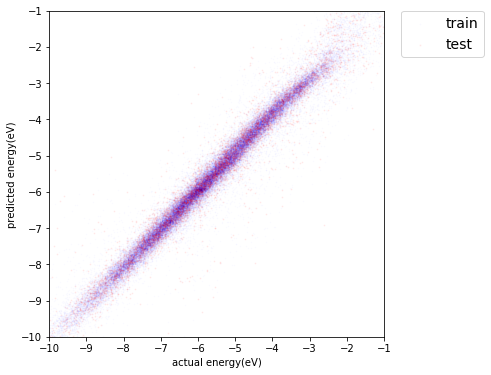

In [11]:
#energy
import matplotlib.pyplot as plt
#visualization of train and test prediction
## energy
predicted_energy = loaded_model.predict(X_train)[:][1]
actual_energy =  energy_train

predicted_test_energy = loaded_model.predict(X_test)[:][1]
test_energy = energy_test
plt.figure(figsize=(6,6))
plt.scatter(actual_energy,predicted_energy,alpha =0.01,s=1,color="blue",label="train")
plt.scatter(test_energy,predicted_test_energy,alpha = 0.05, s=1, color="red",label="test")
lgnd = plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=14)
# plt.title('Melting point predicted vs actual')
plt.xlim(-10,-1)
plt.ylim(-10,-1)
plt.ylabel('predicted energy(eV)')
plt.xlabel('actual energy(eV)')
# plt.legend(['train', 'test'], loc='upper left')
plt.savefig("./energy_evaluation.png",bbox_extra_artists=(lgnd,), bbox_inches='tight',dpi=200)
plt.show()

In [12]:
import tensorflow as tf

def reset_weights(model,weights=None):
    for layer in model.layers:
        print("---------------")
        print(layer)
        if isinstance(layer, tf.keras.Model): #if you're using a model as a layer
            reset_weights(layer) #apply function recursively
            continue
        if hasattr(layer, 'cell'):
            init_container = layer.cell
        else:
            init_container = layer

        for key, initializer in init_container.__dict__.items():
            if ("kernel_initializer" or "recurrent_initializer") not in key: #is this item an initializer?
                  continue #if no, skip it
            else:
                print("key:")
                print(key)
                print("initializer:")
                print(initializer)
                weights = layer.get_weights()
                weights = [initializer(w.shape, w.dtype) for w in weights] 
                layer.set_weights(weights)
from tensorflow.keras.models import load_model
reset_weights(loaded_model)
#epoch optimization test
epoch_optimization_model = loaded_model.fit(X_train,[symmetry_train,energy_train],epochs=50,validation_split=0.2)

---------------
---------------
---------------
key:
kernel_initializer
initializer:
---------------
key:
kernel_initializer
initializer:
---------------
---------------
key:
kernel_initializer
initializer:
---------------
key:
kernel_initializer
initializer:
---------------
---------------
key:
kernel_initializer
initializer:
---------------
key:
kernel_initializer
initializer:
---------------
---------------
---------------
key:
kernel_initializer
initializer:
---------------
---------------
---------------
---------------
key:
kernel_initializer
initializer:
---------------
---------------
---------------
---------------
---------------
key:
kernel_initializer
initializer:
---------------
---------------
key:
kernel_initializer
initializer:
Epoch 1/50
1597/1597 [==============================] - 27s 17ms/step - loss: 5.6692 - classification_head_1_loss: 3.9785 - regression_head_1_loss: 1.6907 - classification_head_1_accuracy: 0.1499 - regression_head_1_mean_absolute_error: 0.8817 - 

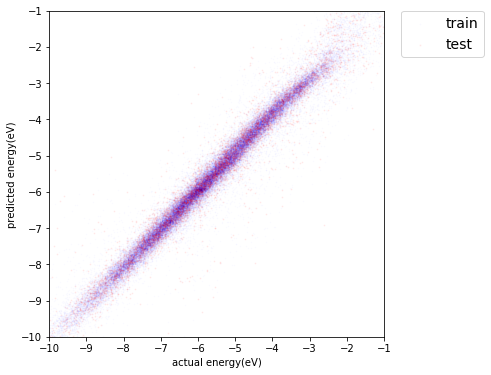

R2 test: 0.9443107939398616
R2 train: 0.9606917288381468


In [10]:
#energy
import matplotlib.pyplot as plt
#visualization of train and test prediction
## energy
predicted_energy = loaded_model.predict(X_train)[:][1]
actual_energy =  energy_train

predicted_test_energy = loaded_model.predict(X_test)[:][1]
test_energy = energy_test
plt.figure(figsize=(6,6))
plt.scatter(actual_energy,predicted_energy,alpha =0.01,s=1,color="blue",label="train")
plt.scatter(test_energy,predicted_test_energy,alpha = 0.05, s=1, color="red",label="test")
lgnd = plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=14)
# plt.title('Melting point predicted vs actual')
plt.xlim(-10,-1)
plt.ylim(-10,-1)
plt.ylabel('predicted energy(eV)')
plt.xlabel('actual energy(eV)')
# plt.legend(['train', 'test'], loc='upper left')
# plt.savefig("./energy_evaluation.png",bbox_extra_artists=(lgnd,), bbox_inches='tight',dpi=200)
plt.show()
#R^2値
from sklearn.metrics import r2_score
print("R2 test: {}".format(r2_score(test_energy,predicted_test_energy)))
print("R2 train: {}".format(r2_score(actual_energy,predicted_energy)))